# Programming Assignment 2 : Computational Photography [EE5176]
### Adarsh Sanodia [ee22b083]

## Question 1: Motion deblurring with conventional Camera

In [72]:
# Necessary imports
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
from scipy.linalg import toeplitz

In [73]:
def plot_image (image, title, cmap=None, axis = 'off'):
    plt.imshow(image,cmap=cmap)
    plt.axis(axis)
    plt.title(title)
    plt.show()

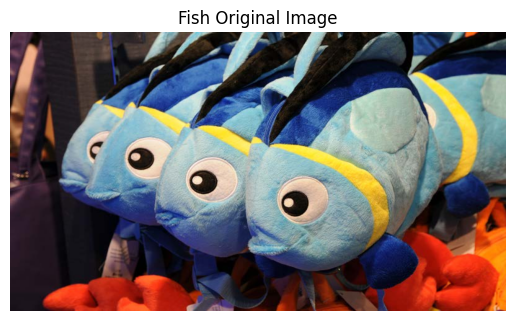

In [74]:
fish_image = Image.open("./data/fish.png")
plot_image(fish_image, "Fish Original Image")

### Part a) Generating blurred image and averaging

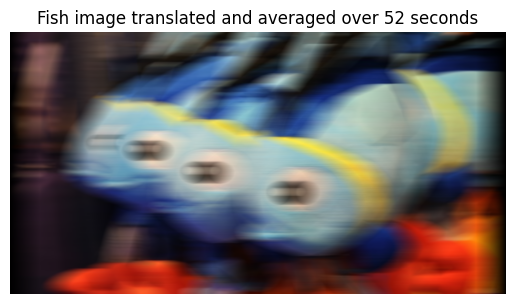

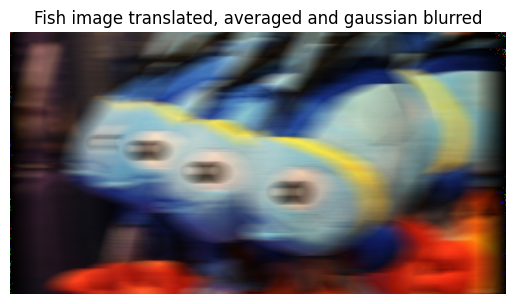

In [75]:
def translate_average_gaussianblur (image, t_max, filepath=None):

    #get the numpy array of the image
    image_numpy_array = np.array(image)

    #create a container to keep the final image in, also make a temporary container to do calculations on
    M,N,channels = image_numpy_array.shape
    final_image = np.zeros((M,N+t_max-1,channels), dtype = np.float64)
  

    # keep translating and adding the image values
    for t in range(t_max):
        temp_translate = np.zeros((M,N+t_max-1,channels), dtype = np.float64)
        temp_translate[:,t:t+N,:] = image_numpy_array
        final_image += temp_translate

    #average the values at the end
    final_image = final_image/t_max
    maximum = np.max(final_image)
    #gaussian blur
    if filepath is not None:
        gaussian_noise = scipy.io.loadmat(filepath)
        for key, value in gaussian_noise.items():
            if not key.startswith('__'):
                mat_kernel = value
                break
        
        final_image += mat_kernel
                

    #convert back to plotable from
    final_image = final_image.astype(np.uint8)
    # final_image = Image.fromarray(final_image)

    
    return final_image

fish_blurred_averaged = translate_average_gaussianblur(fish_image,52)
plot_image(fish_blurred_averaged, "Fish image translated and averaged over 52 seconds")

fish_blurred_gaussian = translate_average_gaussianblur(fish_image, 52, './data/gaussNoise.mat')
plot_image(fish_blurred_gaussian, "Fish image translated, averaged and gaussian blurred")

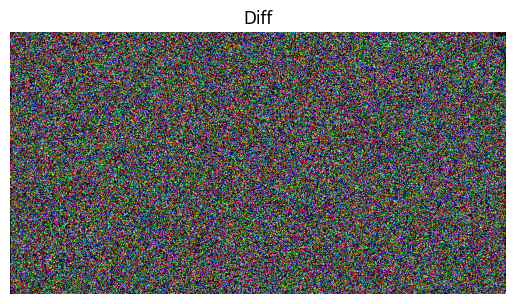

In [76]:
#difference

diff = np.array(fish_blurred_gaussian) - np.array(fish_blurred_averaged)

diff = Image.fromarray(diff)

plot_image(diff, "Diff")

### Part b) Generating blur matrix A


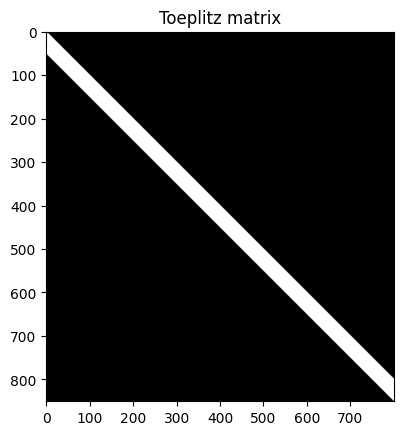

In [77]:
kernel_size = 52
first_column = np.zeros(np.array(fish_image).shape[1] + kernel_size - 1)
first_column[:kernel_size] = 1 / kernel_size
first_row = np.zeros(np.array(fish_image).shape[1])
first_row[0] = 1

A = toeplitz(first_column, first_row)
# A = find_blur_matrix(fish_image, fish_blurred_averaged)
plot_image(A,"Toeplitz matrix",cmap="grey", axis = 'on')



### Part C) Deblurring using Toeplitz matrix

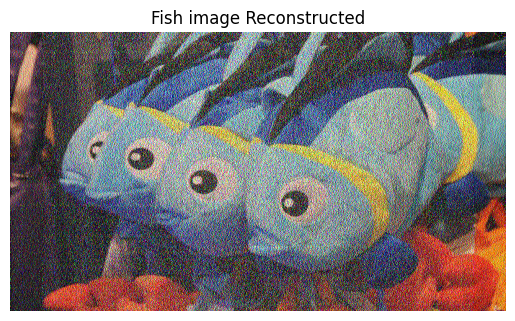

In [78]:
def deblur_image(blurred_image, blur_kernel):
    A = np.array(blur_kernel)
    b = np.array(blurred_image)

    Ai = np.linalg.pinv(A)
    deblurred_image = Ai @ b
    
    return np.clip(deblurred_image,0,255).astype(np.uint8)

fish_image_reconstructed = deblur_image(fish_blurred_gaussian, A)

plot_image(fish_image_reconstructed, "Fish image Reconstructed")



In [79]:
def RMSE(original, recons):
    original = np.array(original)
    recons = np.array(recons)
    diff = (original/255 - recons/255) ** 2
    mean = np.mean(diff)
    return np.sqrt(mean)

print(f"RMSE = {RMSE(fish_image, fish_image_reconstructed)}")
    

RMSE = 0.3433169318768441


RMSE OBTAINED = 0.343

### Part d) Observation from the deblurred image

- From the deblurring we get an Image with the noise amplified because of the following- 
- We know $ y(x) = h(x) * i(x) + n(x)$.
- In Frequency Domain $ Y(jw) = H(jw) * I(jw) N(jw)$ .
- When taking Inverse $I'(jw) = I(jw) + N(jw)/H(jw)$.
- Here zeroes or less magnitude of $H(jw)$ causes noise to amplify resulting in a noisy image.

## Question 2: Flutter Shutter

(i) 1010000111000001010000110011110111010111001001100111 <br>
(ii) 1010101010101010101010101010101010101010101010101010

### Part a) Generating Blurred Image

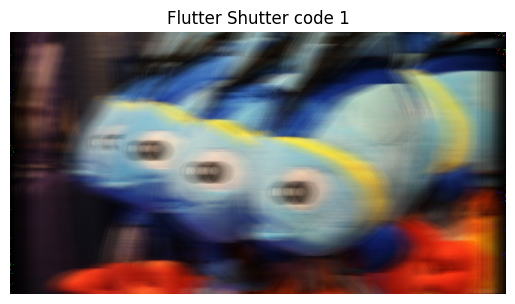

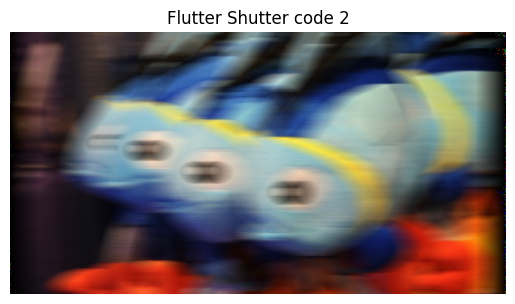

In [80]:
def flutter_shutter(image, code, filepath=None):
    #get the numpy array of the image
    image_numpy_array = np.array(image)

    #create a container to keep the final image in, also make a temporary container to do calculations on
    M,N,channels = image_numpy_array.shape
    t_max = len(code)
    final_image = np.zeros((M,N+t_max-1,channels), dtype = np.float64)

    # keep translating and adding the image values
    count = 0
    for t in range(0,t_max,1):
        temp_translate = np.zeros((M,N+t_max-1,channels), dtype = np.float64)
        if(code[t] == '1'):
            count += 1
            temp_translate[:,t:t+N] = image_numpy_array
            final_image += temp_translate
    #average the values at the end
    final_image = final_image/count

    #gaussian blur
    if filepath is not None:
        gaussian_noise = scipy.io.loadmat(filepath)
        for key, value in gaussian_noise.items():
            if not key.startswith('__'):
                mat_kernel = value
                break
        
        final_image += mat_kernel
                

    #convert back to plotable from
    final_image = final_image.astype(np.uint8)
    final_image = Image.fromarray(final_image)

    
    return final_image

flutter_1_no_noise = flutter_shutter(fish_image, "1010000111000001010000110011110111010111001001100111")
flutter_1 = flutter_shutter(fish_image, "1010000111000001010000110011110111010111001001100111", filepath = './data/gaussNoise.mat')
plot_image(flutter_1, title="Flutter Shutter code 1")

flutter_2_no_noise = flutter_shutter(fish_image, "1010101010101010101010101010101010101010101010101010")
flutter_2 = flutter_shutter(fish_image, "1010101010101010101010101010101010101010101010101010", filepath = './data/gaussNoise.mat')
plot_image(flutter_2, title="Flutter Shutter code 2")


### Part b) Generating Blur Kernel

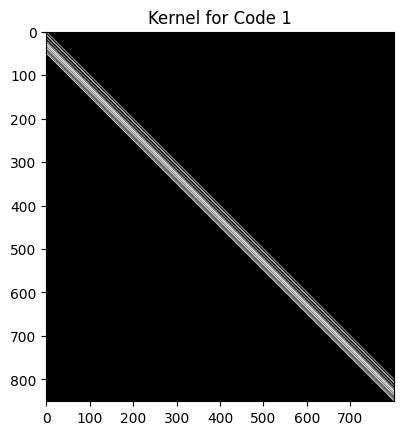

(851, 800)


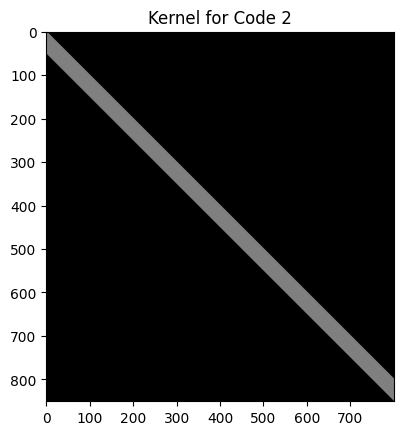

In [81]:
def generate_blur_kernel(original_image, code_length, code):
    original_image = np.array(original_image)
    N = original_image.shape[1]
    blur_kernel = [1/26 if code[i] == "1" else 0 for i in range(len(code))]
    
    kernel = toeplitz(np.concatenate([blur_kernel, np.zeros(N-1)]), np.zeros(N))
    return kernel




kernel_code_1 = generate_blur_kernel(fish_image, 52, "1010000111000001010000110011110111010111001001100111")
plot_image(kernel_code_1, title="Kernel for Code 1", axis="On", cmap = "grey")
print(kernel_code_1.shape)
kernel_code_2 = generate_blur_kernel(fish_image, 52, "1010101010101010101010101010101010101010101010101010")
plot_image(kernel_code_2, title="Kernel for Code 2", axis="On", cmap = "grey")


### Part C) 52 point DFT for the given codes

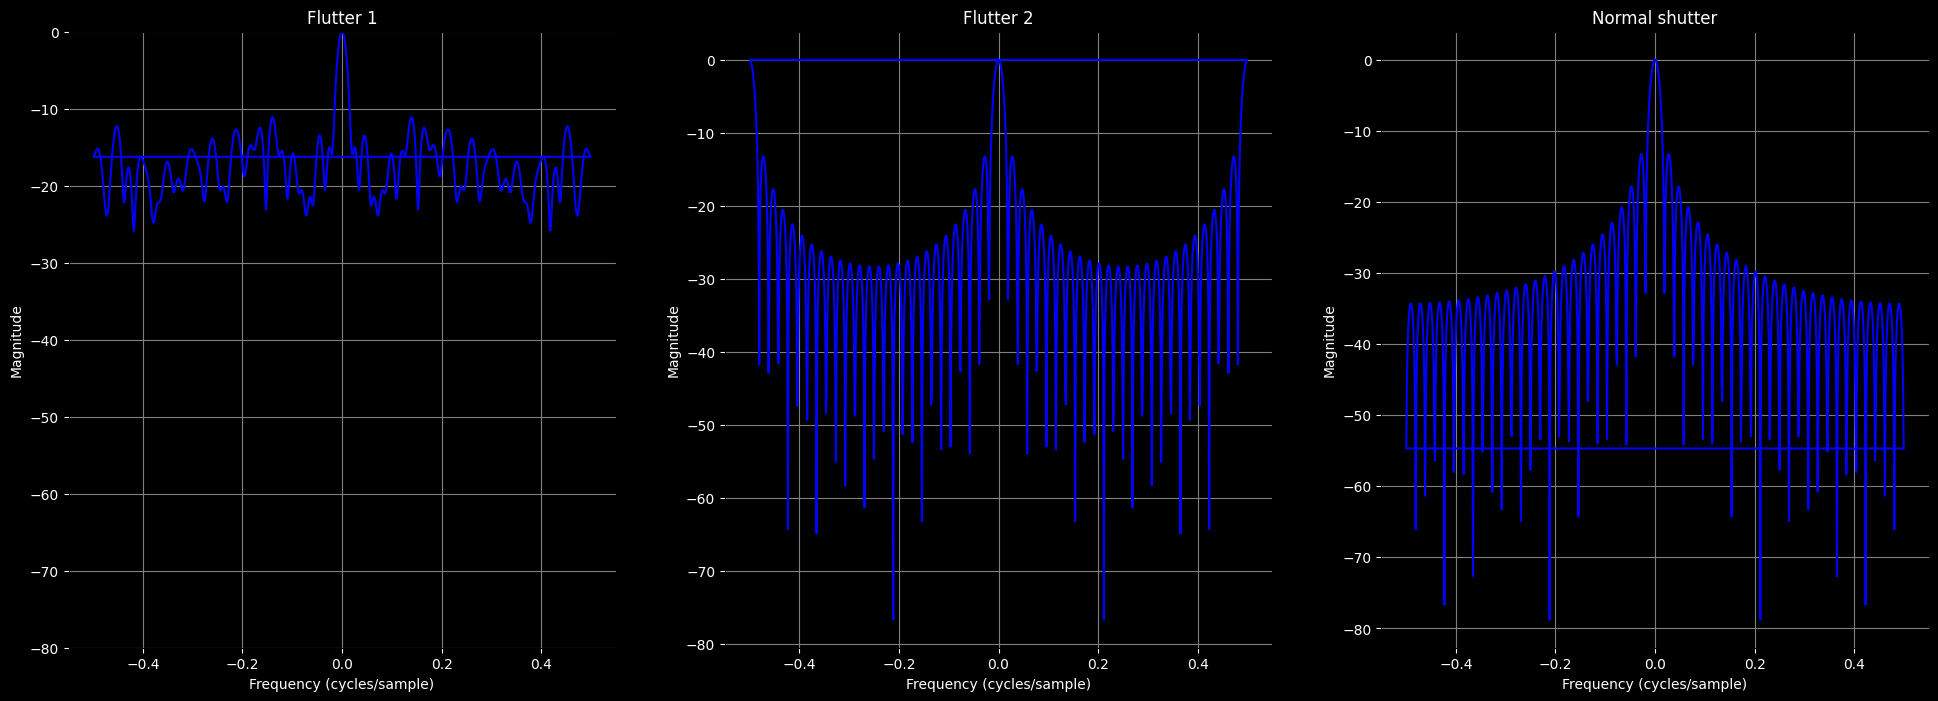

In [82]:
X = np.fft.fft(kernel_code_1[:, 0])

N_x = len(kernel_code_1[:, 0])
frequencies_x = np.fft.fftfreq(N_x)

magnitude_x = np.abs(X)
magnitude_db_x = 20 * np.log10(magnitude_x)

Y = np.fft.fft(kernel_code_2[:, 0])

N_y = len(kernel_code_2[:, 0])
frequencies_y = np.fft.fftfreq(N_y)

magnitude_y = np.abs(Y)
magnitude_db_y = 20 * np.log10(magnitude_y)


Z = np.fft.fft(A[:, 0])

N_z = len(A[:, 0])
frequencies_z = np.fft.fftfreq(N_z)

magnitude_z = np.abs(Z)
magnitude_db_z = 20 * np.log10(magnitude_z)


plt.figure(figsize=(24, 8), facecolor='black')

plt.subplot(1, 3, 1)
plt.gca().set_facecolor('black')
plt.plot(frequencies_x, magnitude_db_x, color='blue')
plt.title('Flutter 1', color = 'white')
plt.xlabel('Frequency (cycles/sample)', color = 'white')
plt.ylabel('Magnitude', color = 'white')
plt.grid(color = 'grey')
plt.tick_params(axis='both', colors='white')
# plt.xlim(-0.5, 0.5)
plt.ylim(-80, 0)

plt.subplot(1, 3, 2)
plt.gca().set_facecolor('black')
plt.plot(frequencies_y ,magnitude_db_y, color='blue')
plt.title('Flutter 2', color = 'white')
plt.xlabel('Frequency (cycles/sample)', color = 'white')
plt.ylabel('Magnitude', color = 'white')
plt.grid(color = 'grey')
plt.tick_params(axis='both', colors='white')
# plt.xlim(-0.5, 0.5)

plt.subplot(1, 3, 3)
plt.gca().set_facecolor('black')
plt.plot(frequencies_z, magnitude_db_z, color='blue')
plt.title('Normal shutter', color = 'white')
plt.xlabel('Frequency (cycles/sample)', color = 'white')
plt.ylabel('Magnitude', color = 'white')
plt.grid(color = 'grey')
plt.tick_params(axis='both', colors='white')
# plt.xlim(-0.5, 0.5)


- When plotting the DFTs as we can see there are points with lower magnitudes in the Conventional Camera case as well as the binary code for the flutter shutter. Points with $Magnitude = -80dB$ implies $H(jw) = 10^-4$ which amplifies the noise a lot.
- For the Flutter shutter code made by us there are not many dips and the least magnitude is $-25dB$ thus the noise isnt amplified much which results in a cleaner deblurred image.

### Part d) Deblurring using blur kernel

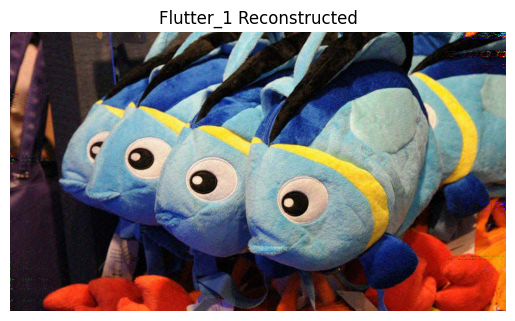

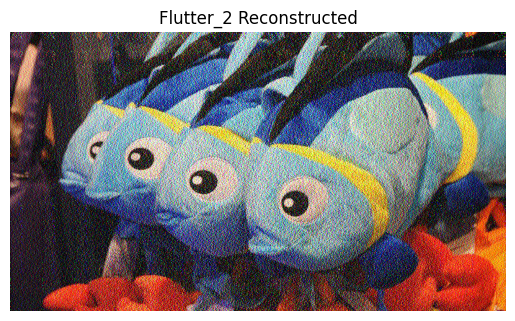

In [83]:
#using old function made for deblurring
reconstructed_image_1 = deblur_image(flutter_1, kernel_code_1)
reconstructed_image_2 = deblur_image(flutter_2, kernel_code_2)

reconstructed_image_1_no_noise = deblur_image(flutter_1_no_noise, kernel_code_1)
reconstructed_image_2_no_noise = deblur_image(flutter_2_no_noise, kernel_code_2)

#plotting reconstructed images
plot_image(reconstructed_image_1, "Flutter_1 Reconstructed")
plot_image(reconstructed_image_2, "Flutter_2 Reconstructed")


### Part e) RMSE calculation

In [84]:
print(f"RMSE of image 1 = {RMSE(fish_image, reconstructed_image_1)}")
print(f"RMSE of image 2 = {RMSE(fish_image, reconstructed_image_2)}")

RMSE of image 1 = 0.041812516743824996
RMSE of image 2 = 0.2132175861561043


#### RMSE Comparison

- *Flutter-1 RMSE:* 0.0418
- *Flutter-2 RMSE:* 0.2132

#### Analysis

The difference in RMSE values can be attributed to the frequency characteristics observed in the Fourier transform of the flutter codes. 

- *Flutter-1:* The frequency band is broadband and its magnitude is not as low as the other so as to amplify the noise
- *Flutter-2:* It has lower magnitudes at high frequencies around 1e-4 which amplifies the noise which can be seen in the deblurred image.

This analysis highlights why Flutter-1 outperforms Flutter-2 in terms of noise reduction capabilities.

### Part f) Noise absent

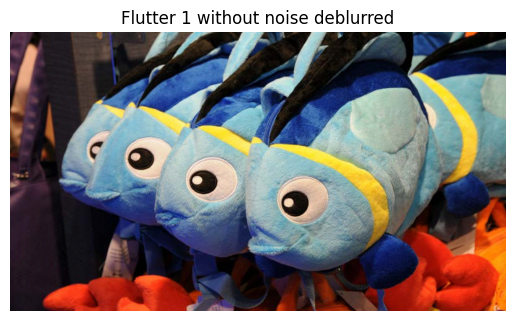

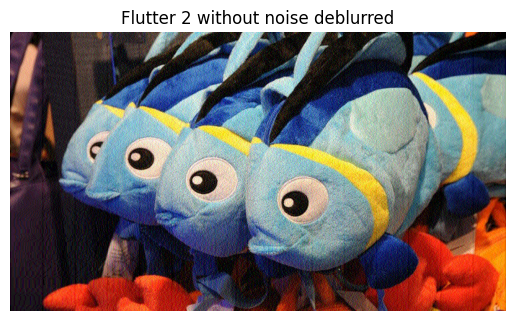

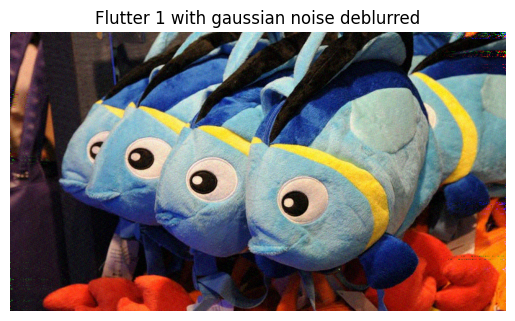

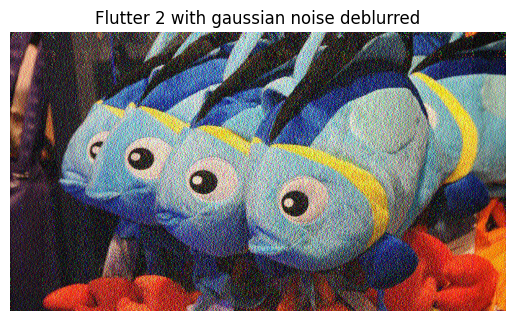

In [85]:
plot_image(reconstructed_image_1_no_noise, title="Flutter 1 without noise deblurred")
plot_image(reconstructed_image_2_no_noise, title="Flutter 2 without noise deblurred")
plot_image(reconstructed_image_1, title="Flutter 1 with gaussian noise deblurred")
plot_image(reconstructed_image_2, title="Flutter 2 with gaussian noise deblurred")


## Image Deblurring Results

The image deblurred without noise is exceptionally clear, with an RMSE that is nearly negligible. This clarity is attributed to the absence of noise, which eliminates high-frequency components. 

While both methods perform effectively under these conditions, Flutter-1 still delivers superior results.

## Question 3

### Part a) Generating blurred image of car and merging with background

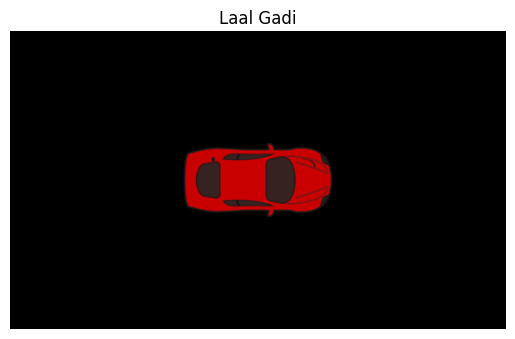

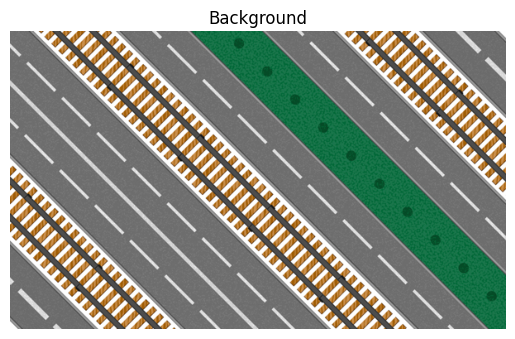

In [86]:
redcar = Image.open('./data/redcar.png')
scene = Image.open('./data/background.png')
plot_image(redcar, title="Laal Gadi")
plot_image(scene, title="Background")

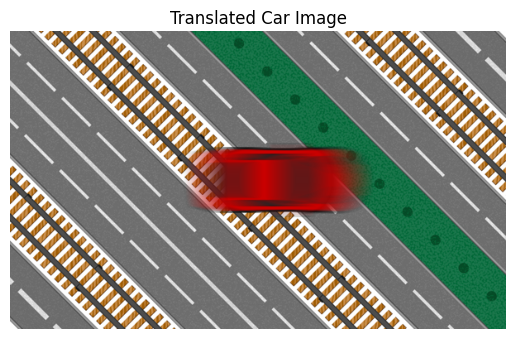

In [87]:
def translate_and_merge(foreground, background):
    foreground = np.array(foreground).astype(np.float64)
    background = np.array(background).astype(np.float64)
    M, N, channels = background.shape
    
    
    b_r, b_g, b_b = background[:,:,0], background[:,:,1], background[:,:,2]
    m_r, m_g, m_b = np.zeros((M,N)), np.zeros((M,N)), np.zeros((M,N))
    
    
    temp = np.zeros((M,N,channels))
    merged = np.zeros((M,N,channels))
    
    
    for i in range(52):
        temp = np.hstack([foreground[:, -i:, :], foreground[:, :-i, :]])
        r,g,b = temp[:,:,0],temp[:,:,1],temp[:,:,2]

        mask = (r != 0) | (g != 0) | (b != 0)    
        m_r += np.where(mask, r, b_r)
        m_g += np.where(mask, g, b_g)
        m_b += np.where(mask, b, b_b)

    
    m_r/=52
    m_g/=52
    m_b/=52

    merged = np.stack((m_r, m_g, m_b), axis=2)
    
    return merged.astype(np.uint8)

car_translated_merged = translate_and_merge(redcar, scene)
plot_image(car_translated_merged, title="Translated Car Image")

### Part b) Motion invariant photography

0
52.0
1
48.07692307692308
2
44.30769230769231
3
40.69230769230769
4
37.23076923076923
5
33.92307692307693
6
30.76923076923077
7
27.76923076923077
8
24.923076923076923
9
22.230769230769234
10
19.692307692307693
11
17.30769230769231
12
15.076923076923078
13
13.0
14
11.076923076923077
15
9.307692307692308
16
7.6923076923076925
17
6.230769230769231
18
4.923076923076923
19
3.7692307692307696
20
2.769230769230769
21
1.9230769230769231
22
1.2307692307692308
23
0.6923076923076923
24
0.3076923076923077
25
0.07692307692307693
26
0.0
27
0.07692307692307693
28
0.3076923076923077
29
0.6923076923076923
30
1.2307692307692308
31
1.9230769230769231
32
2.769230769230769
33
3.7692307692307696
34
4.923076923076923
35
6.230769230769231
36
7.6923076923076925
37
9.307692307692308
38
11.076923076923077
39
13.0
40
15.076923076923078
41
17.30769230769231
42
19.692307692307693
43
22.230769230769234
44
24.923076923076923
45
27.76923076923077
46
30.76923076923077
47
33.92307692307693
48
37.23076923076923
49
40.69

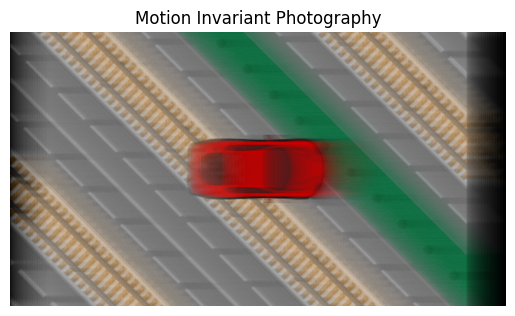

In [88]:
def shift_bg(arr, i):
    M, N, channels = arr.shape
    result = np.zeros((M, N + 104, channels), dtype=arr.dtype)
    result[:, i:N+i, :] = arr 
    return result[:,:N+52,:]


def motion_invariant_photography (foreground, background, camera_shake_filepath):
    foreground = np.array(foreground)
    background = np.array(background)

    camera_shake_file = scipy.io.loadmat(camera_shake_filepath)
    for key, value in camera_shake_file.items():
        if not key.startswith('__'):
            camera_shake = value
            break

    max_shift = np.max(camera_shake)
    camera_shake = camera_shake[0][:-1]


    M,N,channels = background.shape
    N = N + max_shift
    N = N.astype(int)
    merged = np.zeros((M,N,channels))
    m_r = np.zeros((M,N))
    m_g = np.zeros((M,N))
    m_b = np.zeros((M,N))

    for j in range(52):
        temp = np.zeros((M,N,channels))
        temp = shift_bg(background, camera_shake[j].astype(int))
        temp2 = np.zeros((M,N,channels))
        temp2 = shift_bg(foreground, j+camera_shake[j].astype(int))


        mask = (temp2[:,:,0]!=0) | (temp2[:,:,1]!=0) | (temp2[:,:,2]!=0)
        m_r += np.where(mask, temp2[:,:,0], temp[:,:,0])
        m_g += np.where(mask, temp2[:,:,1], temp[:,:,1])
        m_b += np.where(mask, temp2[:,:,2], temp[:,:,2])
        # merged += np.where(mask, temp2, temp)
    m_r /= 52
    m_g /= 52
    m_b /= 52

    merged = np.stack((m_r, m_g, m_b), axis=2)
    return merged.astype(np.uint8)
    
car_scene_translation = motion_invariant_photography(redcar,scene,'./data/CameraT.mat')
plot_image(car_scene_translation, 'Motion Invariant Photography')


### Part C) Comparision of parts a and b above

#### Comaprision
- Comparing the image obtained in both parts it can be seen that
- For part-a the background is clear since only car is moving
- For part-b the backgorund and car both are blurred since car and camera both are moving
- It can be seen that car is more clear in part-b in comparision to part-a

### Part d) Plotting the psf of blurred image made in part b

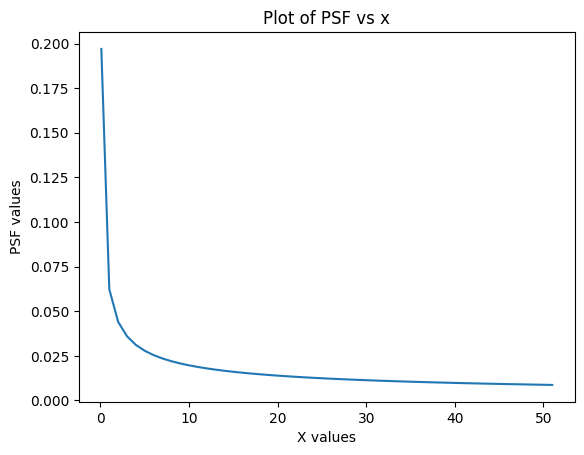

In [93]:
def psf_find_plot(arr, a=1/13):
    #conversion
    arr = np.array(arr)
    
    #get psf
    psf = 1 / np.sqrt(a * arr)

    #find sum and normalize
    sum_psf = sum(psf)
    norm_factor = 1/sum_psf
    psf *= norm_factor

    #plot it
    plt.xlabel('X values')
    plt.ylabel('PSF values')
    plt.title('Plot of PSF vs x')
    plt.plot(arr, psf)
    
    return psf


psf_array = [i for i in range(1,52)]
psf_array.insert(0, 0.1)

psf = psf_find_plot(psf_array)

### Part e) Using psf to form the blur matrix A


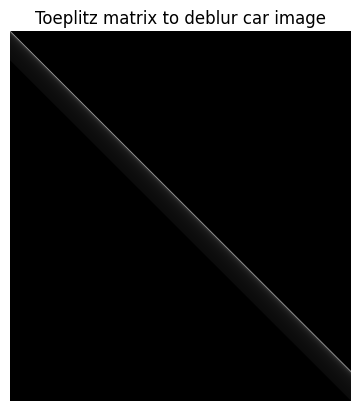

In [95]:
def new_blur_matrix(psf, original_image):

    M,N, channels = np.array(original_image).shape
    kernel = toeplitz(np.concatenate([psf, np.zeros(N)]), np.zeros(N))
    
    return kernel

A_question_3 = new_blur_matrix(psf, car_translated_merged)
plot_image(A_question_3, title = "Toeplitz matrix to deblur car image", cmap = "grey")



### Part f) Deblurring using blur matrix A

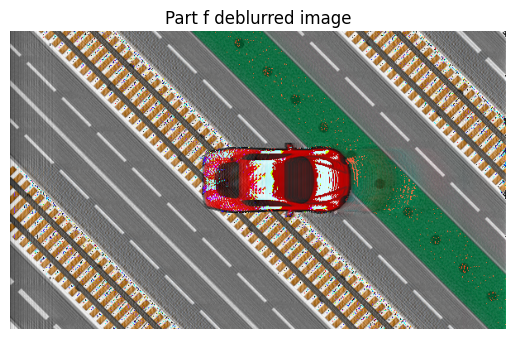

In [91]:
def deblur_using_psf(A, B):
    inverse = np.linalg.pinv(A)
    return (inverse @ B).astype(np.uint8)

final_deblurred_image_question_3 = deblur_using_psf(A_question_3, car_scene_translation)
plot_image(final_deblurred_image_question_3, title = "Part f deblurred image")